# Polynômes de chaos : application au cas de la poutre encastrée


## Résumé

Dans ce notebook, nous présentons la décomposition en chaos polynomial du cas de la poutre encastrée. Nous montrons comment obtenir les indices de Sobol' à partir d'un chaos polynomial.

# Model definition

In [1]:
import openturns as ot
import numpy as np
import tqdm as tqdm
import openturns.viewer as otv
import pylab as pl

In [2]:
fast_simulation = True
if fast_simulation:
    test_sample_size = 100
    maximum_polynomial_degree = 10
else:
    test_sample_size = 1000
    maximum_polynomial_degree = 20

In [3]:
ot.__version__

'1.21'

In [4]:
dist_E = ot.Beta(0.9, 2.2, 2.8e7, 4.8e7)
dist_E.setDescription(["E"])
F_para = ot.LogNormalMuSigma(3.0e4, 9.0e3, 15.0e3)  # in N
dist_F = ot.ParametrizedDistribution(F_para)
dist_F.setDescription(["F"])
dist_L = ot.Uniform(250.0, 260.0)  # in cm
dist_L.setDescription(["L"])
dist_I = ot.Beta(2.5, 1.5, 310.0, 450.0)
dist_I.setDescription(["I"])

myDistribution = ot.ComposedDistribution([dist_E, dist_F, dist_L, dist_I])
myDistribution

Index,Variable,Distribution
0,E,"Beta(alpha = 0.9, beta = 2.2, a = 2.8e+07, b = 4.8e+07)"
1,F,class=ParametrizedDistribution parameters=class=LogNormalMuSigma name=Unnamed mu=30000 sigma=9000 gamma=15000 distribution=class=LogNormal name=LogNormal dimension=1 muLog=9.46206 sigmaLog=0.554513 gamma=15000
2,L,"Uniform(a = 250, b = 260)"
3,I,"Beta(alpha = 2.5, beta = 1.5, a = 310, b = 450)"


In [5]:
dim_input = 4  # dimension of the input
dim_output = 1  # dimension of the output


def function_beam(X):
    E, F, L, I = X
    Y = F * (L**3) / (3 * E * I)
    return [Y]


g = ot.PythonFunction(dim_input, dim_output, function_beam)
g.setInputDescription(myDistribution.getDescription())

## Create a polynomial chaos decomposition

In [6]:
def ComputeSparseLeastSquaresChaos(
    inputTrain,
    outputTrain,
    multivariateBasis,
    totalDegree,
    myDistribution,
    verbose=False,
):
    """
    Create a sparse polynomial chaos with least squares.

    * Uses the enumeration rule from multivariateBasis.
    * Uses LeastSquaresStrategy to compute the coefficients from
    linear least squares.
    * Uses LeastSquaresMetaModelSelectionFactory to select the polynomials
    in the basis using least angle regression stepwise (LARS)
    * Utilise LeastSquaresStrategy pour calculer les
    coefficients par moindres carrés.
    * Uses FixedStrategy to keep all coefficients that LARS has selected,
    up to the given maximum total degree.

    Parameters
    ----------
    inputTrain : ot.Sample(n)
        The input training design of experiments with n points
    outputTrain : ot.Sample(n)
        The input training design of experiments with n points
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    totalDegree : int
        The maximum total polynomial degree
    myDistribution : ot.Distribution
        The distribution of the input random vector

    Returns
    -------
    result : ot.FunctionalChaosResult
        The polynomial chaos result
    """
    selectionAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
    projectionStrategy = ot.LeastSquaresStrategy(
        inputTrain, outputTrain, selectionAlgorithm
    )
    enumerateFunction = multivariateBasis.getEnumerateFunction()
    strataIndex = enumerateFunction.getMaximumDegreeStrataIndex(totalDegree)
    maximumBasisSize = enumerateFunction.getStrataCumulatedCardinal(strataIndex)
    if verbose:
        print("maximumBasisSize = ", maximumBasisSize)
    adaptiveStrategy = ot.FixedStrategy(multivariateBasis, maximumBasisSize)
    chaosalgo = ot.FunctionalChaosAlgorithm(
        inputTrain, outputTrain, myDistribution, adaptiveStrategy, projectionStrategy
    )
    chaosalgo.run()
    result = chaosalgo.getResult()
    return result

On crée la base polynomiale multivariée par tensorisation de polynômes univariés avec la règle d'énumération linéaire par défaut.

In [7]:
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [dist_E, dist_F, dist_L, dist_I]
)

Generate an training sample of size N with MC simulation (or retrieve the design from experimental data).

In [8]:
training_sample_size = 50  # Size of the training design of experiments

inputTrain = myDistribution.getSample(training_sample_size)
outputTrain = g(inputTrain)

totalDegree = 5  # Polynomial degree
result = ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution, True
)
result

maximumBasisSize =  126


Index,Multi-index,Coeff.
0,"[0,0,0,0]",12.57633
1,"[1,0,0,0]",-1.531824
2,"[0,1,0,0]",3.684184
3,"[0,0,1,0]",0.392794
4,"[0,0,0,1]",-1.009399
5,"[2,0,0,0]",0.1801709
6,"[1,1,0,0]",-0.4187929
7,"[1,0,1,0]",-0.03230616
8,"[1,0,0,1]",0.1420621
9,"[0,2,0,0]",-0.09377698


La méthode `getMetaModel` retourne une fonction permettant d'évaluer le métamodèle.

In [9]:
metamodel = result.getMetaModel()  # get the metamodel
type(metamodel)

openturns.func.Function

## Validate the metamodel

Generate a validation sample (which is independent of the training sample).

In [10]:
test_sample_size = 1000  # Size of the validation design of experiments
inputTest = myDistribution.getSample(test_sample_size)
outputTest = g(inputTest)

La classe `MetaModelValidation` permet de valider le métamodèle sur une base de validation.

In [11]:
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)

Compute the $Q^2$ predictivity coefficient

In [12]:
Q2 = val.computePredictivityFactor()[0]
Q2

0.9935498537159471

Plot the observed versus the predicted outputs.

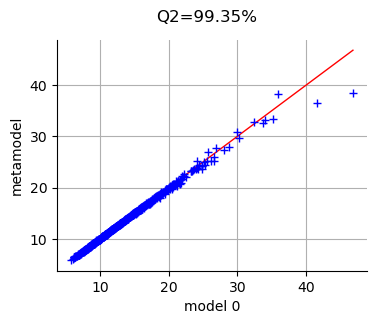

In [13]:
graph = val.drawValidation()
graph.setTitle("Q2=%.2f%%" % (Q2 * 100))
view = otv.View(
    graph,
    figure_kw={"figsize": (4.0, 3.0)},
)

## Sensitivity analysis

Retrieve Sobol' sensitivity measures associated to the polynomial chaos decomposition of the model.

In [14]:
chaosSI = ot.FunctionalChaosSobolIndices(result)
chaosSI

class=FunctionalChaosSobolIndices functional chaos result=class=FunctionalChaosResult derived from  metaModel=class=Function name=Unnamed implementation=class=ComposedFunction name=Unnamed description=[E,F,L,I,y0] left function=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,v0] evaluationImplementation=class=DualLinearCombinationEvaluation functions=[class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[0.935347,2.23044],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[-1.66667,0.000111111],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[0,1.73205],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[-0.57735,2.3094]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=3 values=[-0.755511,2.3618,4.63277],class=UniVariatePolynomial coeffi

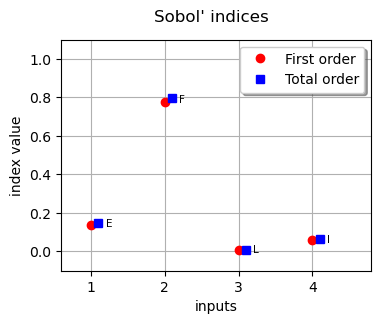

In [15]:
first_order = [chaosSI.getSobolIndex(i) for i in range(dim_input)]
total_order = [chaosSI.getSobolTotalIndex(i) for i in range(dim_input)]
input_names = g.getInputDescription()
graph = ot.SobolIndicesAlgorithm.DrawSobolIndices(input_names, first_order, total_order)
view = otv.View(
    graph,
    figure_kw={"figsize": (4.0, 3.0)},
)

## Solution de l'exercice 1 : réduction de la taille du plan d'expériences d'apprentissage


Puisque nous réduisons la taille du plan d'expérience, il s'avère que le calcul d'un chaos de qualité est plus difficile. Pour rendre l'estimation des coefficients moins sensible au plan d'expériences, nous suggérons de réduire le degré du polynôme. Un degré maximum égal à 1 fonctionne souvent correctement.

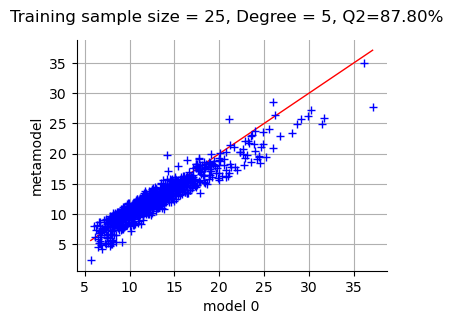

In [16]:
training_sample_size = 25  # size of the experimental design
inputTrain = myDistribution.getSample(training_sample_size)
outputTrain = g(inputTrain)
#
result = ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
)
metamodel = result.getMetaModel()  # get the metamodel
#
inputTest = myDistribution.getSample(test_sample_size)
outputTest = g(inputTest)
#
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
Q2 = val.computePredictivityFactor()[0]
graph = val.drawValidation()
graph.setTitle(
    "Training sample size = %d, Degree = %d, Q2=%.2f%%"
    % (training_sample_size, totalDegree, 100 * Q2)
)
view = otv.View(
    graph,
    figure_kw={"figsize": (4.0, 3.0)},
)

On observe que le coefficient $Q^2$ est moins élevé qu'avec le plan d'expériences précédent. 

In [17]:
def compute_degree_sensitivity(
    myDistribution,
    g,
    training_sample_size,
    test_sample_size,
    multivariateBasis,
    degree_array,
    verbose=False,
):
    """
    Compute a table reflecting the sensitivity to the polynomial degree.

    The content is:
    * first column : polynomial degree
    * second column : predictivity coefficient Q2
    * third column : number of coefficients

    Parameters
    ----------
    myDistribution : ot.Distribution
        The input distribution.
    g : ot.Function
        The model.
    training_sample_size : int
        The size of the training sample.
    test_sample_size : int
        The size of the test sample.
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    degree_array : list of int
        The list of maximum total polynomial degrees
    verbose : bool
        If True, print messages.

    Returns
    -------
    data : numpy array((len(degree_array), 3))
        The results of the experiment.
    """
    data = np.zeros((len(degree_array), 3))
    index = 0
    for totalDegree in degree_array:
        # 1. Fit
        inputTrain = myDistribution.getSample(training_sample_size)
        outputTrain = g(inputTrain)
        result = ComputeSparseLeastSquaresChaos(
            inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
        )
        metamodel = result.getMetaModel()  # get the metamodel
        # 2. Test
        inputTest = myDistribution.getSample(test_sample_size)
        outputTest = g(inputTest)
        val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
        Q2 = val.computePredictivityFactor()[0]
        coefficients = result.getCoefficients()
        numberOfParameters = coefficients.getSize()
        if verbose:
            print(
                "Sample size=%d, degree=%d, Q2=%.4f %%"
                % (training_sample_size, totalDegree, Q2)
            )
        data[index, :] = (totalDegree, Q2, numberOfParameters)
        index += 1
    return data

In [18]:
def print_data(data):
    number_of_rows = data.shape[1]
    for j in range(number_of_rows):
        print(
            "    Degree = %d, Q2 = %.4f, nb. of coeff. = %d"
            % (data[j, 0], data[j, 1], data[j, 2])
        )
    return None

In [19]:
training_sample_size_array = [25, 50, 100]
degree_array = list(range(1, 6))
for training_sample_size in training_sample_size_array:
    print("Sample size=", training_sample_size)
    data = compute_degree_sensitivity(
        myDistribution,
        g,
        training_sample_size,
        test_sample_size,
        multivariateBasis,
        degree_array,
        verbose=False,
    )
    print_data(data)

Sample size= 25
    Degree = 1, Q2 = 0.9771, nb. of coeff. = 5
    Degree = 2, Q2 = 0.9958, nb. of coeff. = 11
    Degree = 3, Q2 = 0.9914, nb. of coeff. = 9
Sample size= 50
    Degree = 1, Q2 = 0.9766, nb. of coeff. = 5
    Degree = 2, Q2 = 0.9988, nb. of coeff. = 14
    Degree = 3, Q2 = 0.9987, nb. of coeff. = 18
Sample size= 100
    Degree = 1, Q2 = 0.9777, nb. of coeff. = 5
    Degree = 2, Q2 = 0.9996, nb. of coeff. = 13
    Degree = 3, Q2 = 1.0000, nb. of coeff. = 31


On observe que le coefficient de prédictivité est sensible à la taille du plan d'expériences. Pour un plan d'expériences de taille 25, le coefficient de prédictivité peut être négatif, ce qui révèle un très mauvais métamodèle. Pour un plan d'expériences de taille 50, le coefficient de prédictivité est la plupart du temps très bon. Toutefois, augmenter le degré du polynôme au delà du degré 2 n'améliore pas beaucoup la qualité. Pour un plan d'expériences de taille 100, le coefficient de prédictivité est toujours très bon. 

In [20]:
training_sample_size = 100
print("Sample size=", training_sample_size)
degree_array = range(1, maximum_polynomial_degree, 2)
data = compute_degree_sensitivity(
    myDistribution,
    g,
    training_sample_size,
    test_sample_size,
    multivariateBasis,
    degree_array,
    verbose=False,
)
print_data(data)

Sample size= 100
    Degree = 1, Q2 = 0.9741, nb. of coeff. = 5
    Degree = 3, Q2 = 1.0000, nb. of coeff. = 26
    Degree = 5, Q2 = 0.9990, nb. of coeff. = 44


On observe que pour un plan d'expériences de taille 100, augmenter le degré du polynôme au delà de 3 n'est pas très utile. En effet, le degré 3 permet d'obtenir un Q2 égal à 0.99 avec seulement 16 coefficients. Lorsqu'on augmente le degré total, la méthode de sélection de modèle n'identifie que très peu de coefficients supplémentaires et ces coefficients n'améliorent pas beaucoup la qualité.  

Pour améliorer la qualité du métamodèle, plusieurs options sont possibles.
1. La taille du plan d'expériences pourrait être augmentée. C'est une option qui nécessite d'évaluer la fonction $g$ sur un plus grand nombre de points d'entrée, ce qui peut être coûteux.
1. Le degré du polynôme pourrait être modifié. En effet, un polynôme de degré moins élevé est associé à un moins grand nombre de coefficients, qui sont plus faciles à estimer. Au contraire, il peut s'avérer que le modèle est très nonlinéaire, ce qui peut nécessiter un degré polynomial élevé.
1. On peut changer de plan d'expériences et utiliser, par exemple, une séquence à faible discrépance ou un plan LHS. C'est une option qui nécessite d'évaluer la fonction $g$ sur des nouveaux points d'entrée, ce qui peut être coûteux.
1. On pourrait changer la base polynomiale orthogonale univariée. Par exemple, il se peut que la base orthogonale associée à la loi log-normale pose une difficulté dans ce cas particulier (car la distribution log-normale n'est pas déterminée de manière unique par ses moments). On pourrait remplacer la famille de polynômes associée à la variable $F$ par la famille des polynômes de Laguerre, qui est également associée à des variables positives comme la loi log-normale.
1. On pourrait changer la règle d'énumération par une règle qui favorise les coefficients associés aux degrés élevés, sans augmenter excessivement le nombre de coefficients, comme la règle hyperbolique par exemple.

Que signifie un $Q^2$ négatif ? On sait que le coefficient $Q^2$ est ((Ross, 2004) page 377) : 
$$
Q^2(g(\boldsymbol{x}_v),\tilde{g}(\boldsymbol{x}_v)) 
= 1 - \frac{ \sum_{j=1}^n \left( y^{(j)}_v - \tilde{y}^{(j)}_v \right)^2}
{ \sum_{j=1}^n \left( y^{(j)}_v - \bar{y}_v \right)^2 }.
$$
où $\left\{y^{(j)}_v\right\}_{j = 1, ...,n}$ est l'échantillon de validation.


- If $y^{(j)}_t = \tilde{y}^{(j)}_t$ for $j = 1, ..., n$ (perfect prediction), 
then $R^2 = 1$. 
- If $y^{(j)}_t = \bar{y}_v$ for $j = 1, ..., n$ (constant prediction), 
then $R^2 = 0$. 
- $R^2 < 0$ : the prediction is worse than a constant prediction $\bar{y}_v$. 

**Références**

- Ross, S. (2004).Introduction to probability and statistics for engineers and scientists. Elsevier. Academic Press.


In [21]:
def compute_Q2_score(
    myDistribution,
    g,
    training_sample_size,
    test_sample_size,
    multivariateBasis,
    totalDegree,
    verbose=False,
):
    """
    Compute the cross-validation Q2 score of the PCE

    Parameters
    ----------
    myDistribution : ot.Distribution
        The input distribution.
    g : ot.Function
        The model.
    training_sample_size : int
        The size of the training sample.
    test_sample_size : int
        The size of the test sample.
    multivariateBasis : ot.Basis
        The multivariate orthogonal polynomial basis
    totalDegree : int
        The total polynomial degree
    verbose : bool
        If True, print messages.

    Returns
    -------
    data : numpy array((len(degree_array), 3))
        The results of the experiment.
    """
    # 1. Fit
    inputTrain = myDistribution.getSample(training_sample_size)
    outputTrain = g(inputTrain)
    result = ComputeSparseLeastSquaresChaos(
        inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
    )
    metamodel = result.getMetaModel()  # get the metamodel
    # 2. Test
    inputTest = myDistribution.getSample(test_sample_size)
    outputTest = g(inputTest)
    val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
    Q2 = val.computePredictivityFactor()[0]
    Q2 = max(0.0, Q2)
    return Q2

In [22]:
def computeGeometricIntegerList(initial, factor, number):
    """
    Create a list of integegers having a geometric progression

    Parameters
    ----------
    initial : int
        The initial integer.
    factor : float, > 1.0
        The increasing factor.
    number : int
        The number of required ints.

    Returns
    -------
    listOfIntegers : list(int)
        The required integers.

    """
    current = initial
    listOfIntegers = [initial]
    for i in range(1, number):
        current = int(factor * current)
        listOfIntegers.append(current)
    return listOfIntegers

Sample sizes =  [10, 20, 40, 80, 160, 320, 640, 1280]


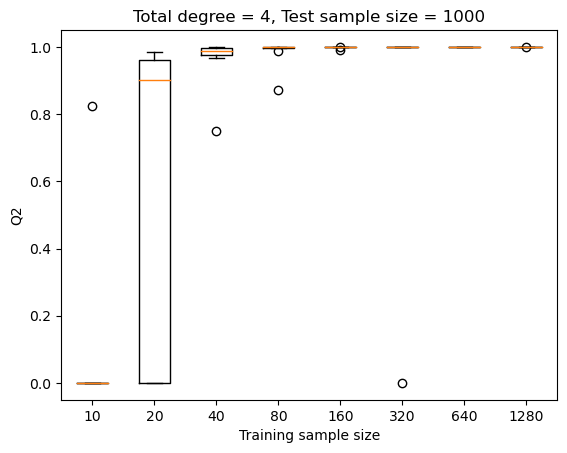

In [23]:
numberOfRepetitions = 10
numberOfSampleSizes = 8
sampleSizeFactor = 2.0
initialSampleSize = 10
test_sample_size = 1000
totalDegree = 4
training_sample_size_array = computeGeometricIntegerList(
    initialSampleSize, sampleSizeFactor, numberOfSampleSizes
)
print("Sample sizes = ", training_sample_size_array)

totalNumberOfExperiments = numberOfRepetitions * numberOfSampleSizes
experimentResult = ot.Sample(numberOfRepetitions, numberOfSampleSizes)
for sizeIndex in range(numberOfSampleSizes):
    training_sample_size = training_sample_size_array[sizeIndex]
    for repetitionIndex in range(numberOfRepetitions):
        Q2 = compute_Q2_score(
            myDistribution,
            g,
            training_sample_size,
            test_sample_size,
            multivariateBasis,
            totalDegree,
            verbose=False,
        )
        experimentResult[repetitionIndex, sizeIndex] = Q2

_ = pl.boxplot(np.array(experimentResult))
pl.title("Total degree = %d, Test sample size = %d" % (totalDegree, test_sample_size))
_ = pl.xticks(range(1, 1 + numberOfSampleSizes), training_sample_size_array)
_ = pl.xlabel("Training sample size")
_ = pl.ylabel("Q2")

On observe qu'une taille d'échantillon d'apprentissage inférieure ou égale à $n = 160$ ne permet pas d'obtenir un $Q^2$ supérieur ou égal à 0.9 de manière robuste. C'est particulièrement vrai si la taille du plan d'expériences d'apprentissage est inférieure ou égale à 40. 

## Solution de l'exercice 2 : pourquoi éviter le calcul du R2

Get the relative error of the metamodel on the training sample, compute $R^2$.

In [24]:
result.getRelativeErrors()[0]

0.00514439755396117

$R^2$ indicator:

In [25]:
R2 = 1 - result.getRelativeErrors()[0]
print(r"R2 = %.4f" % R2)

R2 = 0.9949


On observe que le coefficient $R^2$ est très proche de 1. Cela laisse penser que le métamodèle est d'excellente qualité, ce qui peut être vrai ou faux en fonction des situations. Dans tous les cas, ce n'est pas nécessairement une bonne métrique pour qualifier le métamodèle : on préfère en général utiliser un plan d'expérience de validation et calculer le coefficient $Q^2$. 

## Solution de l'exercice 3

In [26]:
def plotCoefficientValueVSDegree(polynomialChaosResult):
    """
    Create a plot of total degree vs absolute value of coefficients.

    Parameters
    ----------
    polynomialChaosResult : ot.FunctionalChaosResult
        The polynomial chaos result

    Returns
    -------
    graph : ot.Graph
        A plot.
    """
    basis = polynomialChaosResult.getOrthogonalBasis()
    enumerate_function = basis.getEnumerateFunction()
    # Get coefficients
    coefficients = polynomialChaosResult.getCoefficients()
    abscoeff = [abs(coefficients[i][0]) for i in range(len(coefficients))]
    # Get total degree
    indices = result.getIndices()
    nbcoeffs = indices.getSize()
    total_p = []
    for k in range(nbcoeffs):
        multiindex = enumerate_function(indices[k])
        totaldegree = sum(multiindex)
        total_p.append(totaldegree)
    #
    graph = ot.Graph(
        "Polynomial chaos result",
        "Total polynomial degree",
        "Coefficient absolute value",
        True,
    )
    cloud = ot.Cloud(total_p, abscoeff)
    graph.add(cloud)
    graph.setIntegerXTick(True)
    return graph

Plot the coefficients absolute values as a function of total polynomial degree: high degree polynomials contribute less than low-degree terms to the response's variability

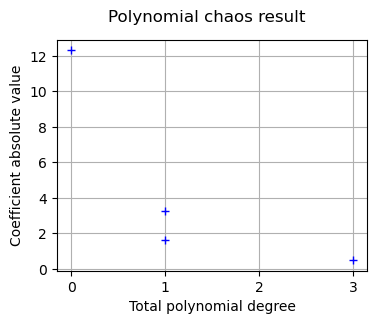

In [27]:
graph = plotCoefficientValueVSDegree(result)
view = otv.View(
    graph,
    figure_kw={"figsize": (4.0, 3.0)},
)

## Solution de l'exercice 4 : énumération hyperbolique et plan d'expériences de taille 100


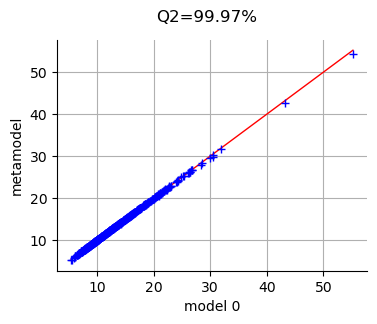

In [28]:
dim_input = 4
polyColl = ot.PolynomialFamilyCollection(dim_input)
polyColl[0] = ot.StandardDistributionPolynomialFactory(dist_E)
polyColl[1] = ot.StandardDistributionPolynomialFactory(dist_F)
polyColl[2] = ot.StandardDistributionPolynomialFactory(dist_L)
polyColl[3] = ot.StandardDistributionPolynomialFactory(dist_I)
#
q = 0.6  # the q-quasi-norm parameter
enumerateFunction = ot.HyperbolicAnisotropicEnumerateFunction(dim_input, q)
multivariateBasis = ot.OrthogonalProductPolynomialFactory(polyColl, enumerateFunction)
#
N = 100  # size of the experimental design
inputTrain = myDistribution.getSample(N)
outputTrain = g(inputTrain)
#
approximationAlgorithm = ot.LeastSquaresMetaModelSelectionFactory()
projectionStrategy = ot.LeastSquaresStrategy(
    inputTrain, outputTrain, approximationAlgorithm
)
totalDegree = 5
strataIndex = enumerateFunction.getMaximumDegreeStrataIndex(totalDegree)
maximumBasisSize = enumerateFunction.getStrataCumulatedCardinal(strataIndex)
adaptiveStrategy = ot.FixedStrategy(multivariateBasis, maximumBasisSize)
chaosalgo = ot.FunctionalChaosAlgorithm(
    inputTrain, outputTrain, myDistribution, adaptiveStrategy, projectionStrategy
)
chaosalgo.run()
#
result = chaosalgo.getResult()
metamodel = result.getMetaModel()  # get the metamodel
#
inputTest = myDistribution.getSample(test_sample_size)
outputTest = g(inputTest)
#
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
Q2 = val.computePredictivityFactor()[0]
graph = val.drawValidation()
graph.setTitle("Q2=%.2f%%" % (100 * Q2))
view = otv.View(
    graph,
    figure_kw={"figsize": (4.0, 3.0)},
)

The metamodel is slightly more accurate than using a linear enumeration (but it sometimes produces a negative $Q^2$).

In [29]:
result

Index,Multi-index,Coeff.
0,"[0,0,0,0]",12.61307
1,"[1,0,0,0]",-1.552808
2,"[0,1,0,0]",3.752801
3,"[0,0,1,0]",0.4279618
4,"[0,0,0,1]",-0.9921519
5,"[2,0,0,0]",0.1895031
6,"[0,2,0,0]",-0.02597062
7,"[0,0,0,2]",0.07865307
8,"[3,0,0,0]",-0.03620794
9,"[1,1,0,0]",-0.4560978


In [30]:
sensitivityAnalysis = ot.FunctionalChaosSobolIndices(result)
ot.ResourceMap.SetAsScalar("FunctionalChaosSobolIndices-VariancePartThreshold", 0.0001)
sensitivityAnalysis

class=FunctionalChaosSobolIndices functional chaos result=class=FunctionalChaosResult derived from  metaModel=class=Function name=Unnamed implementation=class=ComposedFunction name=Unnamed description=[E,F,L,I,y0] left function=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,v0] evaluationImplementation=class=DualLinearCombinationEvaluation functions=[class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[0.935347,2.23044],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[-1.66667,0.000111111],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[0,1.73205],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=1 values=[1],class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=2 values=[-0.57735,2.3094]] gradientImplementation=class=ProductPolynomialGradient hessianImplementation=class=ProductPolynomialHessian,class=Function name=Unnamed implementation=class=FunctionImplementation name=Unnamed description=[x0,x1,x2,x3,y0] evaluationImplementation=class=ProductPolynomialEvaluation, polynomials=[class=UniVariatePolynomial coefficients=class=Point name=Unnamed dimension=3 values=[-0.755511,2.3618,4.63277],class=UniVariatePolynomial coeffi

## Solution de l'exercice 5 : nombre d'observations et nombre de paramètres

In [31]:
coefficients = result.getCoefficients()
numberOfParameters = coefficients.getSize()
print("numberOfParameters = ", numberOfParameters)

trainingSampleSize = inputTrain.getSize()
print("trainingSampleSize = ", trainingSampleSize)

learningRatio = trainingSampleSize / numberOfParameters
print("learningRatio = %.3f" % (learningRatio))

numberOfParameters =  20
trainingSampleSize =  100
learningRatio = 5.000


Si le nombre d'observations est très supérieur au nombre de paramètres, alors l'apprentissage est de qualité. Avec environ 2 observations par paramètres, le nombre d'observations est suffisant, mais il pourrait être plus grand pour assurer une meilleure qualité. 

## Solution de l'exercice 6 : analyse des résultats de la sélection de modèle

In [32]:
def printCoefficientsTable(polynomialChaosResult):
    """
    Print the coefficients of the polynomial chaos.

    Parameters
    ----------
    enumerate_function : ot.EnumerateFunction
        The enumerate function.
    polynomialChaosResult : ot.PolynomialChaosResult
        The polynomial chaos result.
    """
    basis = polynomialChaosResult.getOrthogonalBasis()
    enumerate_function = basis.getEnumerateFunction()
    indices = polynomialChaosResult.getIndices()
    nbcoeffs = indices.getSize()
    print("# Indice, Multi-indice, Degree : Value")
    for k in range(nbcoeffs):
        multiindex = enumerate_function(indices[k])
        degree = sum(multiindex)
        c = coefficients[k][0]
        print("#%d, %s (%s) : %s" % (k, multiindex, degree, c))
    return

Display active polynomials 

In [33]:
indices = result.getIndices()
indices

[0,1,2,3,4,5,6,8,9,13,14,15,16,17,18,23,25,27,28,35]

Display active polynomials coefficients

In [34]:
nbcoeffs = indices.getSize()
nbcoeffs

20

In [35]:
coefficients = result.getCoefficients()
coefficients

,v0
0,12.61307
1,-1.552808
2,3.752801
3,0.4279618
4,-0.9921519
5,0.1895031
6,-0.02597062
7,0.07865307
8,-0.03620794
9,-0.4560978


Print the "sparsity" ratio as the complementary number of selected coefficients divided by total number of candidate polynomials in the basis.

In [36]:
sparsityRatio = 1.0 - nbcoeffs / maximumBasisSize
print("%.2f %%" % (sparsityRatio * 100.0))

48.72 %


Le coefficient de creux est égal à 52%, ce qui est plutôt le signe d'un chaos polynomial de qualité. Comme ce ratio n'est ni trop petit ni trop grand, on peut légitimement conserver la valeur de `P` que l'on a choisie.

Print polynomials degrees and coefficients for active terms.

In [37]:
printCoefficientsTable(result)

# Indice, Multi-indice, Degree : Value
#0, [0,0,0,0] (0) : 12.613073002742746
#1, [1,0,0,0] (1) : -1.5528078219026138
#2, [0,1,0,0] (1) : 3.7528006793727924
#3, [0,0,1,0] (1) : 0.4279618433606038
#4, [0,0,0,1] (1) : -0.9921519375340901
#5, [2,0,0,0] (2) : 0.18950310999553352
#6, [0,2,0,0] (2) : -0.02597062337495044
#7, [0,0,0,2] (2) : 0.0786530696619444
#8, [3,0,0,0] (3) : -0.03620793532785738
#9, [1,1,0,0] (2) : -0.4560977718029406
#10, [1,0,1,0] (2) : -0.04901815953363378
#11, [1,0,0,1] (2) : 0.11112061413914501
#12, [0,1,1,0] (2) : 0.1365168000423447
#13, [0,1,0,1] (2) : -0.2889813096725319
#14, [0,0,1,1] (2) : -0.02502241344272756
#15, [2,1,0,0] (3) : 0.06655315593533706
#16, [2,0,0,1] (3) : -0.01573026531443124
#17, [0,2,1,0] (3) : 0.0043967465193225546
#18, [0,2,0,1] (3) : 0.00252469672356109
#19, [5,0,0,0] (5) : 0.004400986486802655


## Solution de l'exercice 7 : moyenne et écart-type du chaos

In [38]:
def get_PC_mean_sd(functionalChaosResult):
    """
    Return mean and standard deviation of a polynomial chaos.

    This code was adapted from
    https://github.com/openturns/openturns/blob/b5797d7e4a71c71faf86df51f26ad0d8d551ad08/lib/src/Uncertainty/Algorithm/MetaModel/FunctionalChaos/FunctionalChaosSobolIndices.cxx#L68

    See https://github.com/openturns/openturns/issues/1927

    Parameters
    ----------
    functionalChaosResult : ot.FunctionalChaosResult()
        The polynomial chaos.

    Returns
    -------
    mean : ot.Point(outputDimension)
        The expectation of Y = p(X), where p is the polynomial.
    stdDev : ot.Point(outputDimension)
        The standard deviation of Y = pc(X), where pc is the polynomial chaos,
        as the square root of the variance.
    """
    outputDimension = functionalChaosResult.getMetaModel().getOutputDimension()
    indices = functionalChaosResult.getIndices()
    coefficients = functionalChaosResult.getCoefficients()
    basisSize = indices.getSize()
    variance = ot.Point(outputDimension)
    mean = ot.Point(outputDimension)
    for i in range(outputDimension):
        for k in range(basisSize):
            # Take into account only non-zero indices as the
            # null index is the mean of the vector
            if indices[k] > 0:
                variance[i] += coefficients[k, i] ** 2
            else:
                mean[i] = coefficients[k, i]
    # standard deviation
    stdDev = ot.Point(outputDimension)
    for i in range(outputDimension):
        stdDev[i] = np.sqrt(variance[i])
    return mean, stdDev

In [39]:
training_sample_size = 50  # Size of the training design of experiments

inputTrain = myDistribution.getSample(training_sample_size)
outputTrain = g(inputTrain)
totalDegree = 5  # Polynomial degree
result = ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
)

mean, stdDev = get_PC_mean_sd(result)
print("+ From P.C.E.:")
print("    Mean(PC) = %.4f" % (mean[0]))
print("    S.D.(PC) = %.4f" % (stdDev[0]))

chaosRV = ot.FunctionalChaosRandomVector(result)
mean = chaosRV.getMean()[0]
variance = chaosRV.getCovariance()[0, 0]
stdDev = np.sqrt(variance)
print("+ From the output sample of the P.C.E.:")
print("    Mean(PC) = %.4f" % (mean))
print("    S.D.(PC) = %.4f" % (stdDev))

+ From P.C.E.:
    Mean(PC) = 12.6251
    S.D.(PC) = 4.2701
+ From the output sample of the P.C.E.:
    Mean(PC) = 12.6251
    S.D.(PC) = 4.2701


## Solution de l'exercice 8 : base de Hermite

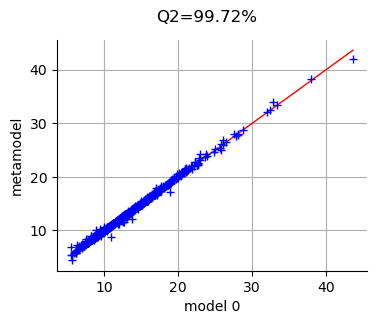

In [40]:
dimension = myDistribution.getDimension()
hermiteFactory = ot.HermiteFactory()
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [hermiteFactory] * dimension, enumerateFunction
)
training_sample_size = 100  # Size of the training design of experiments

inputTrain = myDistribution.getSample(training_sample_size)
outputTrain = g(inputTrain)

totalDegree = 5  # Polynomial degree
result = ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
)
metamodel = result.getMetaModel()

inputTest = myDistribution.getSample(test_sample_size)
outputTest = g(inputTest)
#
val = ot.MetaModelValidation(inputTest, outputTest, metamodel)
Q2 = val.computePredictivityFactor()[0]
graph = val.drawValidation()
graph.setTitle("Q2=%.2f%%" % (100 * Q2))
view = otv.View(
    graph,
    figure_kw={"figsize": (4.0, 3.0)},
)

On observe que la base des polynômes d'Hermite fonctionne très bien dans ce cas particulier. 

- L'avantage de cette méthode est que la base des polynômes d'Hermite est déterminée de manière exacte par la récurrence à trois termes, dont les coefficients sont explicites. En conséquence, la base fonctionnelle créée par tensorisation des polynômes d'Hermite est numériquement proche de l'orthogonalité, même lorsque le degré polynômial est élevé, ce qui est un avantage. Puisque nous utilisons dans le cas de la poutre encastrée un degré polynomial inférieur à 5, cet avantage n'est pas très significatif. 
- Lorsqu'on utilise le schéma de Haskey pour la variable $F$, celle-ci revient à orthogonaliser la distribution log-normale. Or on sait que cette distribution n'est pas déterminée uniquement par ses moments. En conséquence, la base polynomiale générée par le procédé d'orthogonalisation de Stieljes modifié n'est pas une base complète de l'espace des fonctions $L^2$. Cela implique que, lorsqu'on augmente le degré polynomial, on est pas certain de converger vers la vraie fonction (même avec un échantillon de taille hypothétiquement infinie). L'avantage de la base de Hermite est qu'elle forme une base complète, ce qui est un avantage. 
- L'utilisation de la base de Hermite nécessite une transformation iso-probabiliste qui n'est pas nécessairement triviale en fonction des lois marginales du vecteur d'entrée du modèle physique. Dans le cas de la poutre encastrée, nous avons des lois marginales qui ne sont pas gaussiennes, ce qui entraîne une transformation non triviale pour obtenir la distribution standard gaussienne. Cette transformation peut apporter une non linéarité au modèle transformé, ce qui peut nécessiter un degré polynomial plus élevé. Ainsi, à degré polynomial égal, l'approximation par polynôme de chaos de Wiener peut être de moins bonne qualité que celui généré par le schéma de Askey, ce qui est un inconvénient.

## Exercice 9 : approximation de la distribution de la sortie


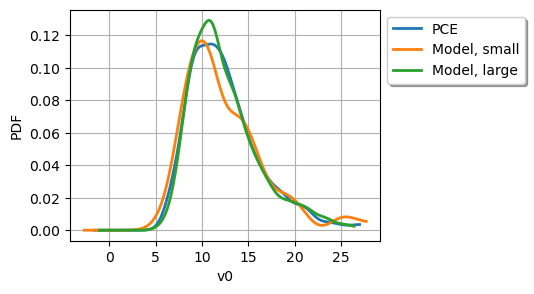

In [41]:
# 1. Create PCE
multivariateBasis = ot.OrthogonalProductPolynomialFactory(
    [dist_E, dist_F, dist_L, dist_I]
)
training_sample_size = 100  # Size of the training design of experiments
inputTrain = myDistribution.getSample(training_sample_size)
outputTrain = g(inputTrain)

totalDegree = 5  # Polynomial degree
result = ComputeSparseLeastSquaresChaos(
    inputTrain, outputTrain, multivariateBasis, totalDegree, myDistribution
)
metamodel = result.getMetaModel()
inputTest = myDistribution.getSample(test_sample_size)
outputTest = g(inputTest)
# 2. Create output sample from PCE and plot the approximate PDF
chaosRV = ot.FunctionalChaosRandomVector(result)
sample_PCE = chaosRV.getSample(1000)
distribution_PCE = ot.KernelSmoothing().build(sample_PCE).drawPDF()
# 3. Compare with approximate PDF from the model
distribution_model_small = ot.KernelSmoothing().build(outputTrain).drawPDF()
distribution_PCE.add(distribution_model_small)
# 4. Compare with approximate PDF from the model, with a large sample
input_test_large = myDistribution.getSample(1000)
output_test_large = g(input_test_large)
distribution_model_large = ot.KernelSmoothing().build(output_test_large).drawPDF()
distribution_PCE.add(distribution_model_large)
# Customize
distribution_PCE.setLegends(["PCE", "Model, small", "Model, large"])
distribution_PCE.setColors(ot.Drawable.BuildDefaultPalette(3))
view = otv.View(
    distribution_PCE,
    figure_kw={"figsize": (4.0, 3.0)},
    legend_kw={"bbox_to_anchor": (1.0, 1.0), "loc": "upper left"},
)